# Creating Image Dataset from Subfolders

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras import applications
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# importing a file with useful functions
from functions import *

---

### Data augmentation

In [ ]:
# data_augmentation() 

# see self-made functions
# default arguments are already specified for this function

---

### Train-validation split

In [3]:
# specify image and batch size
img_height = 56
img_width = 56
image_size = (img_height, img_width)
batch_size = 32

In [72]:
## IMPORTANT: before running this, make sure there is no ipynb_checkpoints in the image files

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
                 '../datasets/augmented/',
                 labels = 'inferred',
                 label_mode = 'int',
                 color_mode = 'rgb',
                 batch_size = batch_size,
                 image_size = image_size,
                 shuffle = True,
                 seed = 42,
                 validation_split = .15,
                 subset = 'training'
)

Found 12620 files belonging to 2 classes.
Using 10727 files for training.


In [73]:
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
                         '../datasets/augmented/',
                         labels = 'inferred',
                         label_mode = 'int',
                         color_mode = 'rgb',
                         batch_size = batch_size,
                         image_size = image_size,
                         shuffle = True,
                         seed = 42,
                         validation_split = .15,
                         subset = 'validation'
)

Found 12620 files belonging to 2 classes.
Using 1893 files for validation.


---

### Plot example images

<ipython-input-74-c50c0ad84e18>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 3, i + 1)


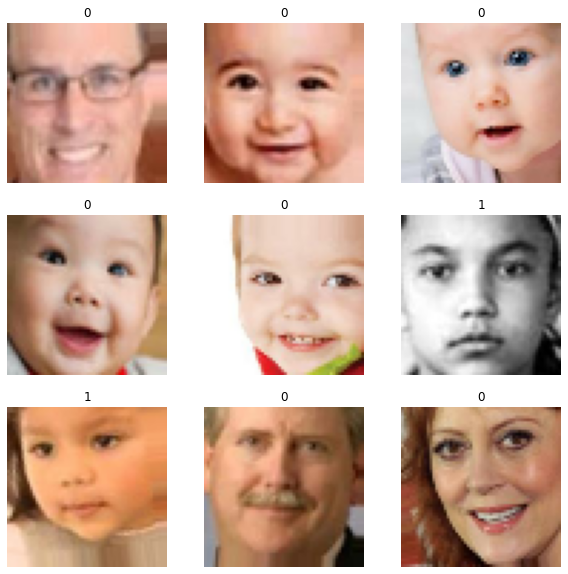

In [74]:
import matplotlib.pyplot as plt    
plt.figure(figsize=(10, 10))

for images, labels in ds_train.take(10):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# 0 --> smile / happy
# 1 --> neutral / serious face

---

### Building the model

In [75]:
ds_train_pref = ds_train.prefetch(buffer_size=32)
ds_validation_pref = ds_validation.prefetch(buffer_size=32)

In [76]:
def make_model(input_shape, num_classes):
    
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    #x = data_augmentation(inputs)
    x = inputs

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x) # rescale the pixel codes
    x = layers.Conv2D(32, 3, strides=2, padding="same", # 1st convolutional 2D layer with 32 nodes
                      kernel_regularizer = keras.regularizers.L2(0.001) 
                     )(x) 
    x = layers.BatchNormalization()(x) # re-center and re-scale the layer's input
    x = layers.Activation("relu")(x) # specify activation function

    x = layers.Conv2D(64, 3, padding="same",  # 2nd convolutional 2D layer with 64 nodes
                      kernel_regularizer = keras.regularizers.L2(0.001) 
                     )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # adding 2 SeparableConv2D layers, then MaxPooling2D
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same",
                                   depthwise_regularizer = keras.regularizers.L2(0.001), pointwise_regularizer = keras.regularizers.L2(0.001)
                                  )(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same",
                                   depthwise_regularizer = keras.regularizers.L2(0.001), pointwise_regularizer = keras.regularizers.L2(0.001)
                                  )(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same" )(
            previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same",
                               depthwise_regularizer = keras.regularizers.L2(0.001), pointwise_regularizer = keras.regularizers.L2(0.001)
                              )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    # define activation function and number of nodes for the output layer, depending on whether
    # binary or multiclass classification
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [77]:
# create the model using the function in the previous cell
model = make_model(input_shape = image_size + (3,), num_classes=2)

In [ ]:
# plot model structure
# keras.utils.plot_model(model, show_shapes=True)

In [78]:
# early stopping
# early_stop = EarlyStopping(patience = 7, monitor='val_loss', mode='min')

# compiling the model
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="bce",
              metrics=["accuracy"] )

# fitting and saving as object named 'history'
history = model.fit(ds_train_pref, epochs=15, 
                    #callbacks=[early_stop],
                    validation_data=ds_validation_pref)

Epoch 1/15
336/336 [==============================] - 130s 380ms/step - loss: 1.8815 - accuracy: 0.8892 - val_loss: 1.4276 - val_accuracy: 0.5066
Epoch 2/15
336/336 [==============================] - 129s 384ms/step - loss: 0.5308 - accuracy: 0.9634 - val_loss: 0.5061 - val_accuracy: 0.9324
Epoch 3/15
336/336 [==============================] - 140s 416ms/step - loss: 0.3439 - accuracy: 0.9743 - val_loss: 0.8411 - val_accuracy: 0.8019
Epoch 4/15
336/336 [==============================] - 134s 397ms/step - loss: 0.2904 - accuracy: 0.9766 - val_loss: 0.3553 - val_accuracy: 0.9424
Epoch 5/15
336/336 [==============================] - 136s 403ms/step - loss: 0.2343 - accuracy: 0.9828 - val_loss: 0.2729 - val_accuracy: 0.9704
Epoch 6/15
336/336 [==============================] - 135s 401ms/step - loss: 0.2092 - accuracy: 0.9825 - val_loss: 0.2712 - val_accuracy: 0.9667
Epoch 7/15
336/336 [==============================] - 132s 393ms/step - loss: 0.1836 - accuracy: 0.9878 - val_loss: 0.2542 -

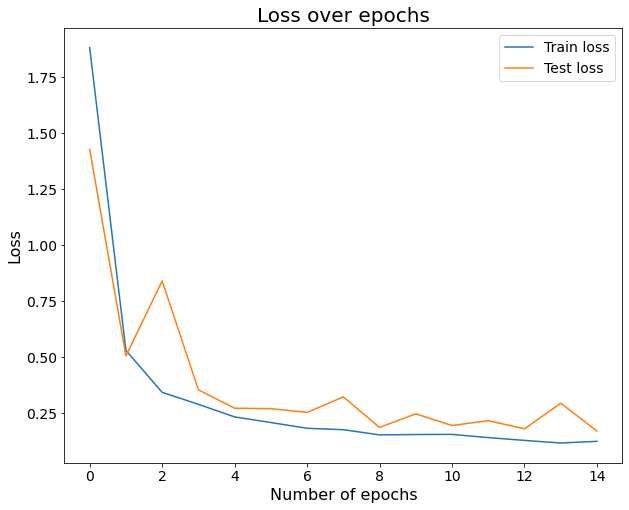

In [83]:
# plot the loss over the number of epochs
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend(loc=1, prop={'size': 14})
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Loss over epochs', fontsize=20);
plt.savefig('../presentation_images/loss_15_epochs.jpeg');

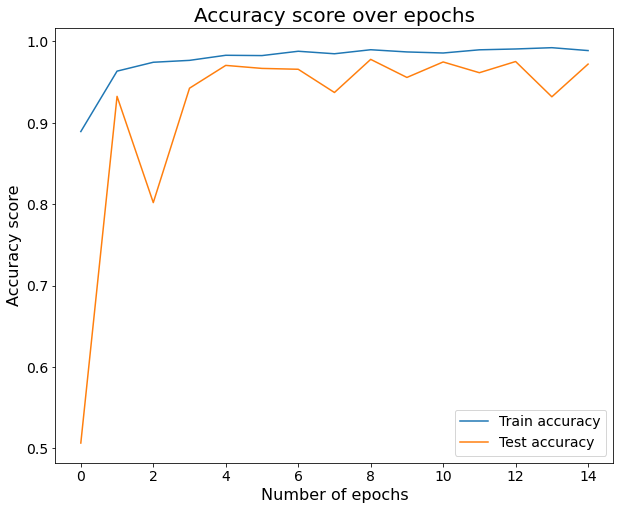

In [84]:
# plot the accuracy over the number of epochs
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.legend(loc=4, prop={'size': 14})
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Accuracy score', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Accuracy score over epochs', fontsize=20);
plt.savefig('../presentation_images/accuracy_15_epochs.jpeg');

In [81]:
# evaluate the model on the training set
model.evaluate(ds_train)

336/336 [==============================] - 27s 81ms/step - loss: 0.1217 - accuracy: 0.9888


[0.12168511003255844, 0.9888132810592651]

In [82]:
# evaluate the model on the validation set
model.evaluate(ds_validation)

60/60 [==============================] - 5s 83ms/step - loss: 0.1711 - accuracy: 0.9720


[0.17112191021442413, 0.9720020890235901]

In [85]:
# save the model
model.save('../saved_models/')

C:\Users\Yair\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ../saved_models/assets


In [3]:
# load the model
# model = keras.models.load_model('../saved_models/')

---

#### Test data

In [4]:
# preparing the test data - workflow and some code taken from:
# https://deeplizard.com/learn/video/LhEMXbjGV_4
# https://deeplizard.com/learn/video/bfQBPNDy5EM

test_batches = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, channel_shift_range=10., horizontal_flip=True) \
             .flow_from_directory(directory='../test',
                                  target_size=(56,56),
                                  classes=['happy', 'neutral'], 
                                  batch_size=10,
                                  shuffle=False)

Found 360 images belonging to 2 classes.


In [5]:
# predictions on the test data
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [21]:
# rounding the predictions
np.round(predictions)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

Confusion matrix, without normalization
[[168  12]
 [  8 172]]


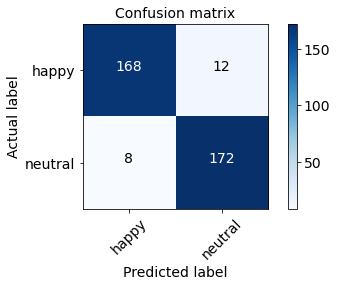

In [43]:
# plot confusion matrix
plt.rcParams.update({'font.size': 14});
plot_confusion_matrix(cm, classes=['happy','neutral']);
plt.title('Confusion matrix',fontsize=14);
plt.xlabel('Predicted label', fontsize=14);
plt.ylabel('Actual label', fontsize=14);
plt.savefig('../presentation_images/confusion_matrix_test.jpeg');

In [6]:
# printing out model metrics for the test data
model_scores(y_true=test_batches.classes, y_pred=np.round(predictions))

,test_data_model_metrics
accuracy,0.938889
misclassification,0.061111
specificity,0.916667
recall_sensitivity,0.961111
precision,0.920213
f1_score,0.940217


In [8]:
# making a table with the predictions on the test data
test_predictions = test_predictions(test_data = test_batches, predictions = predictions)

In [12]:
test_predictions.head(10)

,file,predicted_label,race,age,result
0,happy\10_happy_asian_adults.jpg,happy,asian,adults,1
1,happy\10_happy_asian_babies.jpg,happy,asian,babies,1
2,happy\10_happy_asian_children.jpg,happy,asian,children,1
3,happy\10_happy_asian_elderly.jpg,happy,asian,elderly,1
4,happy\10_happy_dark_adults.jpg,happy,dark,adults,1
5,happy\10_happy_dark_babies.jpg,happy,dark,babies,1
6,happy\10_happy_dark_children.jpg,happy,dark,children,1
7,happy\10_happy_dark_elderly.jpg,happy,dark,elderly,1
8,happy\10_happy_white_adults.jpg,happy,white,adults,1
9,happy\10_happy_white_babies.jpg,happy,white,babies,1


In [10]:
# prediction accuracy brokwn down by race
test_predictions.groupby('race')[['result']].mean()

,result
race,
asian,0.950000
dark,0.900000
white,0.966667


In [11]:
# prediction accuracy brokwn down by age group
test_predictions.groupby('age')[['result']].mean()

,result
age,
adults,0.988889
babies,0.955556
children,0.966667
elderly,0.844444


---